In [15]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB


# vizualization
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

# EDA

In [2]:
labeled_train_data_og = pd.read_csv('./labeledTrainData.tsv', sep='\t')
test_data_og = pd.read_csv('./testData.tsv', sep='\t')
unlabeled_train_data_og = pd.read_csv('./unlabeledTrainData.tsv', sep='\t')

labeled_train_data = labeled_train_data_og.copy()
test_data = test_data_og.copy()
unlabeled_train_data = unlabeled_train_data_og.copy()

print(labeled_train_data.dtypes)
print(test_data.dtypes)
print(unlabeled_train_data.dtypes)
print(labeled_train_data.isnull().sum())
print(test_data.isnull().sum())
print(unlabeled_train_data.isnull().sum())

id           object
sentiment     int64
review       object
dtype: object
id        object
review    object
dtype: object
id        object
review    object
dtype: object
id           0
sentiment    0
review       0
dtype: int64
id        0
review    0
dtype: int64
id        0
review    0
dtype: int64


 positive sentiments in the dataset: 50.0%
1    12500
0    12500
Name: sentiment, dtype: int64


<AxesSubplot: xlabel='sentiment', ylabel='count'>

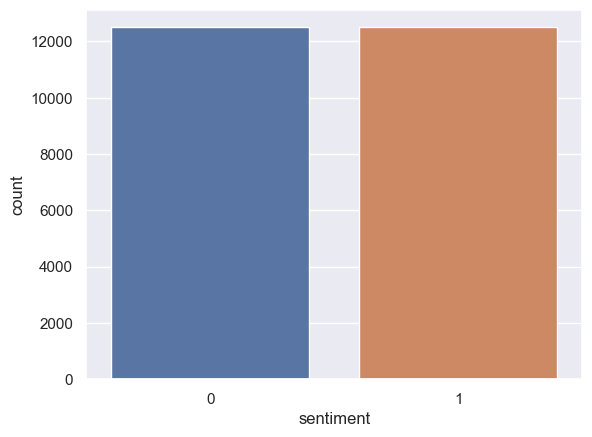

In [3]:
print(f" positive sentiments in the dataset: {labeled_train_data['sentiment'].sum()/len(labeled_train_data['sentiment'])*100}%")
print(labeled_train_data['sentiment'].value_counts())
sns.countplot(data=labeled_train_data, x=labeled_train_data['sentiment'])

## Observations:
* Dataset is balanced.

# Feature Engineering:
* (DONE) Needs lowercasing.
* (DONE) Remove URLs, numbers.
* (DONE) Remove stopwords. 
* (DONE) Remove punctuations.
* Perform Sentence and word tokenization. OR
* (DONE) Perform word tokenization.
* (DONE) Perform Stemming.
* (DONE) Perform Tokenization. 

In [4]:
# labeled_train_data['review'] = labeled_train_data['review'].astype('string')
# test_data['review'] = test_data['review'].astype('string')
# unlabeled_train_data['review'] = unlabeled_train_data['review'].astype('string')

# labeled_train_data['review'] = labeled_train_data['review'].lower()
# test_data['review'] = test_data['review'].lower()
# unlabeled_train_data['review'] = unlabeled_train_data['review'].lower()

stopwords_en = set(stopwords.words('english'))
punctuation_en = set(punctuation)
stopwords_punctuation_en = stopwords_en.union(punctuation_en)
porter = PorterStemmer()

combined_dataset = [labeled_train_data,test_data,unlabeled_train_data]
print(labeled_train_data.loc[20882,'review'])
for dataset in combined_dataset:

    dataset['review'] = dataset['review'].astype('string')
    dataset.replace(to_replace={'review':{r'http\S+':'',r'[0-9]+':'',  r'<br \/>':' ', r'[^A-Za-z0-9# ]+':' '}}, regex=True, inplace=True)
    dataset['review'] = dataset['review'].str.lower().apply(word_tokenize)
    dataset['review'] = dataset['review'].apply(lambda x: [word for word in x if word not in stopwords_punctuation_en])
    dataset['review'] = dataset['review'].apply(lambda x: [porter.stem(word) for word in x ])

print('\n',labeled_train_data.loc[20882,'review'])

A Compelling Thriller!!, 10 December 2005 Author:littlehammer16787 from United States<br /><br />Just Cause<br /><br />Starring:Sean Connery,Laurence Fishburne, and Blair Underwood.<br /><br />A liberal,though good-hearted Harvard law professor Paul Armstrong is convoked to the Flordia Everglades by unjustly convicted black guy Bobby Earl.Confessing that sadistic,cold-hearted cops vilifyied and beat him to a pulp to get the confession of a gruesome murder of an eleven year old girl. As he digs further and further into the mysterious case he realizes that Bobby Earl is a victim of discrimination.That the black police detective Lt.Tanny Brown of the small community is corrupt and villainously mean. When the infamous,psychotic serial killer Blair Sullivan is introduced.He discovers that he knows the location of the murder weapon that butchered the little girl.When Armstrong finds that there are lucid coincidences of Sullivan's road trip through the small town and the letter he personally 

## Observations:
* (DONE) word_tokenizer splits "<\br />" tags and other special chars like "!!". So maybe find a better tokenizer or remove special chars.
* Vectorization would need:
    * (DONE) punctuation removal
    * sentence tokenization instead of word tokenization. Punkt tokenizer maybe? list of sentences having list of words. So, list of list.
    * give it a proper size for our vocabulary. Also set the size equal to the size of the longest sentence.

    

## Vectorization
* Bag of words
* Word2Vec: Continuous Bag of Words
* Word2Vec: SkipGram

# Task 1:  
 Bag of words + Multinomial Naive Bayes

In [41]:
# for dataset in combined_dataset:
#     dataset
labeled_train_data_bow = labeled_train_data.copy()
labeled_train_data_bow['review'] = labeled_train_data_bow['review'].apply(lambda x: ' '.join([word for word in x]))

unlabeled_train_data_bow = unlabeled_train_data.copy()
unlabeled_train_data_bow['review'] = unlabeled_train_data_bow['review'].apply(lambda x: ' '.join([word for word in x]))

test_data_bow = test_data.copy()
test_data_bow['review'] = test_data_bow['review'].apply(lambda x: ' '.join([word for word in x]))


train_data_bow = pd.concat([labeled_train_data_bow[['id','review']],unlabeled_train_data_bow[['id','review']]])

bow = CountVectorizer(stop_words=None, analyzer='word')
labeld_unlabeled_train_features = bow.fit(train_data_bow['review']) # Training dictionary on all training data ie. labeled+unlabeled
labeled_train_data_bow_features = bow.transform(labeled_train_data_bow['review'])
test_features_bow = bow.transform(test_data_bow['review'])

mnb = MultinomialNB()
mnb.fit(labeled_train_data_bow_features, labeled_train_data_bow['sentiment'] )

predictions = mnb.predict(test_features_bow)
result = pd.DataFrame({'id': test_data_bow['id'], 'sentiment': predictions})
result.to_csv('./bow_submission.csv', index = False)


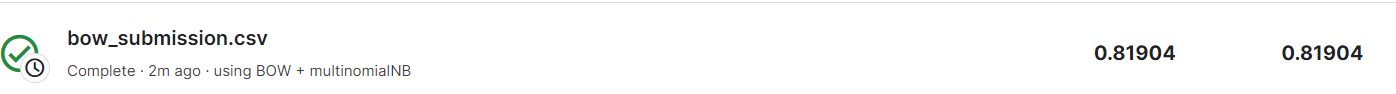

# Task 2:
Word2vec + DNN

In [9]:


cbow = Word2Vec(labeled_train_data['review'], min_count = 5,  window = 10, sg = 0)

cbow.build_vocab(labeled_train_data['review'], progress_per = 1000)
cbow.train(labeled_train_data['review'], total_examples=cbow.corpus_count, epochs = cbow.epochs)

cbow.save("./word2vec_cbow.model")

In [13]:
print(cbow.wv.most_similar('murder', topn=3))
print(cbow.wv.similarity('murder','gruesom'))


[('investig', 0.651408851146698), ('crime', 0.6421923041343689), ('rape', 0.6347212791442871)]
0.5252319
[-4.443966   -1.2492316   0.38741747 -0.705671   -1.7891856   0.03511373
 -0.138797    1.8048542  -1.437218    1.9898726   1.0186739   0.38928246
 -3.6169825  -1.2458111  -2.717638   -3.3896947  -0.66533786 -1.7311133
 -1.0259043  -0.99351025  1.4147625  -1.195566    2.4858186  -1.0812362
 -0.22614071 -2.002418    3.1687717   1.0996482  -4.0230546  -1.7670009
  2.4990568   1.33143     0.1251983   1.5557634  -0.85180223 -0.16791555
 -2.1652975  -0.13353893  0.22727488 -2.1791852  -0.85653484  2.098466
 -6.9534364  -0.5452967   0.85470587  1.3029922   1.2830491   1.2051618
 -2.3421478  -1.4434263   1.9917501   1.6228269  -3.079561   -3.0456893
 -2.4267204  -1.1938876   1.7527596   0.07082767  0.80147433 -3.3978112
  1.1617433  -0.32731327 -3.0445173  -1.4975152  -1.899104    4.233329
  1.9156368  -0.5918841   0.660041   -1.0545527  -1.4231751   0.5705423
 -0.83490735 -2.0551457  -2.86

## TODO:
* Train on unlabeled and labeled train data.
* Do polarity classification
* Check the Size of longest review, this size will be our size of all the vectors.
* Use RFclassifier or LSTM or LDA.